## Imports y datasets

Importamos librerias y funciones a utilizar.

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from sklearn.metrics import f1_score,  recall_score, precision_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping

import pickle

Seteamos una semilla para que los resultados sean reproducibles.

In [110]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE) 

Importamos los datasets a utilizar y los guardamos en variables.

In [111]:
test = pd.read_csv('Datasets/test_encoded.csv').copy()
train = pd.read_csv('Datasets/train_encoded.csv').copy()
original = pd.read_csv('Datasets/hotels_procesado.csv')
original_test = pd.read_csv('Datasets/hotels_test.csv')

In [112]:
train.drop(columns=['Unnamed: 0'], inplace=True)
test.drop(columns=['Unnamed: 0'], inplace=True)

## Normalizacion y split de datasets

Normalizamos los datos a utilizar.

In [113]:
stand_scaler = StandardScaler()
train = stand_scaler.fit_transform(train)
test = stand_scaler.transform(test)

Separamos los datos en train y test cvon una proporcion de 70/30

In [114]:
x = train.copy()
y = original['is_canceled'].copy()

x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y, 
                                                    test_size=0.3,  #proporcion 70/30
                                                    random_state=RANDOM_STATE) #semilla

In [115]:
print('# Datos Entrenamiento: {}'.format(len(x_train)))
print('# Datos Prueba: {}'.format(len(x_test)))

for split_name, split in zip(['% Positivos Entrenamiento','% Positivos Prueba'],[y_train,y_test]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[1]*100))

# Datos Entrenamiento: 37192
# Datos Prueba: 15940
% Positivos Entrenamiento: 50.863
% Positivos Prueba: 50.866


Ahora vamos a variar parámetros creando 3 modelos distintos para ver cual da mejores resultados.

## Modelo 1

Seteamos la cantidad de capas, neuronas por capa y funcion de activacion.

In [116]:
cant_clases = len(np.unique(y_train))
cant_inputs = len(train[0])

modelo_1 = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=[cant_inputs]),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

Vamos a utilizar EarlyStopping como funcion de regularizacion para evitar el overfitting.

In [117]:
es = EarlyStopping(monitor='val_loss', patience=5) 

Acá podemos ver un resumen del modelo.

In [118]:
modelo_1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 64)                10944     
                                                                 
 dense_22 (Dense)            (None, 32)                2080      
                                                                 
 dense_23 (Dense)            (None, 1)                 33        
                                                                 
Total params: 13,057
Trainable params: 13,057
Non-trainable params: 0
_________________________________________________________________


Seteamos parámetros para este primer modelo: cantidad de epochs y optimizador a utilizar, y luego entrenamos el modelo

In [119]:
epochs = 256

In [120]:
modelo_1.compile(
    optimizer= keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
    )

history = modelo_1.fit(x_train, y_train, epochs=epochs, batch_size=64, verbose=1, validation_data = (x_test, y_test), callbacks=[es])

Epoch 1/256
582/582 [==============================] - 3s 4ms/step - loss: 0.4189 - accuracy: 0.7883 - val_loss: 0.3645 - val_accuracy: 0.8219
Epoch 2/256
582/582 [==============================] - 2s 3ms/step - loss: 0.3313 - accuracy: 0.8416 - val_loss: 0.3395 - val_accuracy: 0.8346
Epoch 3/256
582/582 [==============================] - 1s 3ms/step - loss: 0.3063 - accuracy: 0.8553 - val_loss: 0.3335 - val_accuracy: 0.8393
Epoch 4/256
582/582 [==============================] - 1s 2ms/step - loss: 0.2900 - accuracy: 0.8657 - val_loss: 0.3300 - val_accuracy: 0.8391
Epoch 5/256
582/582 [==============================] - 1s 2ms/step - loss: 0.2764 - accuracy: 0.8725 - val_loss: 0.3361 - val_accuracy: 0.8393
Epoch 6/256
582/582 [==============================] - 2s 3ms/step - loss: 0.2659 - accuracy: 0.8780 - val_loss: 0.3407 - val_accuracy: 0.8381
Epoch 7/256
582/582 [==============================] - 2s 3ms/step - loss: 0.2550 - accuracy: 0.8835 - val_loss: 0.3338 - val_accuracy: 0.8443

En el siguiente gráfico podemos ver como varía el error por epoch:

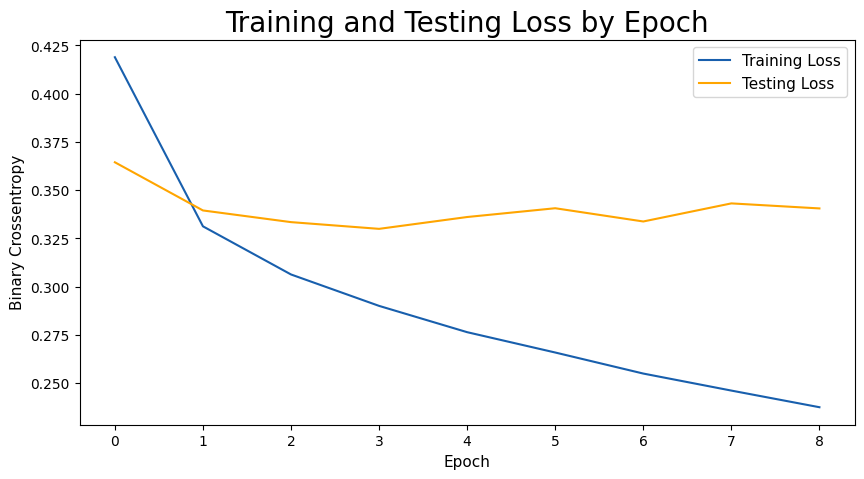

In [121]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')
plt.title('Training and Testing Loss by Epoch', fontsize = 20)
plt.xlabel('Epoch', fontsize = 11)
plt.ylabel('Binary Crossentropy', fontsize = 11)
plt.legend(fontsize = 11)

Acá podemos ver como varía el accuracy por epoch:

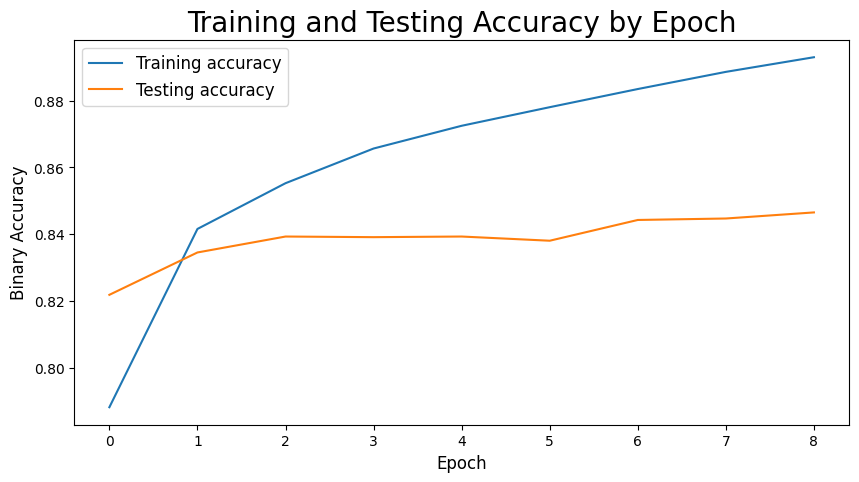

In [122]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Testing accuracy')
plt.title('Training and Testing Accuracy by Epoch', fontsize = 20)
plt.xlabel('Epoch', fontsize = 12)
plt.ylabel('Binary Accuracy', fontsize = 12)
plt.legend(fontsize = 12)

En el siguiente gráfico se puede ver el area bajo la curva:

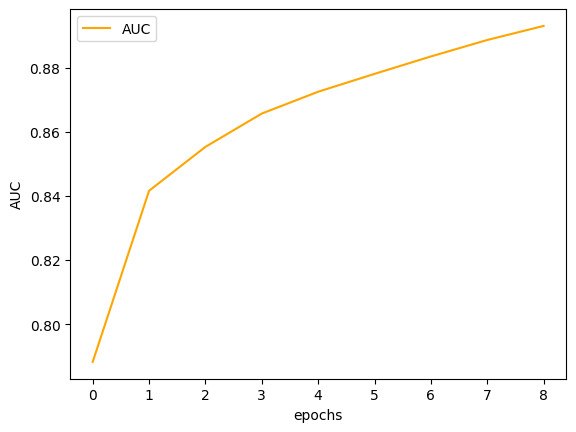

In [123]:
plt.plot(history.history['accuracy'], color='orange', label='AUC')
plt.xlabel("epochs")
plt.ylabel("AUC")
plt.legend()

In [124]:
train_score = modelo_1.evaluate(x_train,
                       y_train,
                       verbose=1)
test_score = modelo_1.evaluate(x_test,
                       y_test,
                       verbose=1)
labels = modelo_1.metrics_names

print('')
print(f'Training Accuracy: {train_score[1]}')
print(f'Testing Accuracy: {test_score[1]}')

499/499 [==============================] - 1s 1ms/step - loss: 0.3406 - accuracy: 0.8465

Training Accuracy: 0.9071574807167053
Testing Accuracy: 0.8465495705604553


In [125]:
y_pred = modelo_1.predict(x_test)

499/499 [==============================] - 1s 1ms/step


In [126]:
y_pred_binario = np.where(y_pred > 0.3851, 1, 0)

accuracy = accuracy_score(y_test, y_pred_binario)
recall = recall_score(y_test, y_pred_binario)
f1 = f1_score(y_test, y_pred_binario,)
precision = precision_score(y_test, y_pred_binario)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8399623588456713
Recall: 0.9036753823384311
Precision: 0.8054303616576893
f1 score: 0.851729148503342


In [127]:
#Reporte de Clasificación
print(classification_report(y_test,y_pred_binario))

              precision    recall  f1-score   support

           0       0.89      0.77      0.83      7832
           1       0.81      0.90      0.85      8108

    accuracy                           0.84     15940
   macro avg       0.85      0.84      0.84     15940
weighted avg       0.84      0.84      0.84     15940



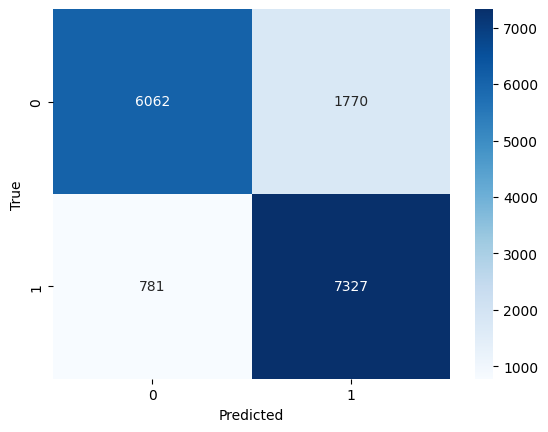

In [128]:
#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred_binario)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Modelo 2

Seteamos la cantidad de capas, neuronas por capa y funcion de activacion.

In [129]:
cant_clases = len(np.unique(y_train))
cant_inputs = len(train[0])

modelo_2 = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=[cant_inputs]),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

Vamos a utilizar EarlyStopping como funcion de regularizacion para evitar el overfitting.

In [130]:
es = EarlyStopping(monitor='val_loss', patience=5) 

Acá podemos ver un resumen del modelo.

In [131]:
modelo_2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 64)                10944     
                                                                 
 dense_25 (Dense)            (None, 32)                2080      
                                                                 
 dense_26 (Dense)            (None, 1)                 33        
                                                                 
Total params: 13,057
Trainable params: 13,057
Non-trainable params: 0
_________________________________________________________________


Seteamos parámetros para este primer modelo: cantidad de epochs y optimizador a utilizar, y luego entrenamos el modelo

In [132]:
epochs = 100

In [133]:
modelo_2.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.01),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'] 
    )

history = modelo_2.fit(x_train, y_train, epochs=epochs, batch_size=64, verbose=1, validation_data = (x_test, y_test), callbacks=[es])

Epoch 1/100
582/582 [==============================] - 2s 3ms/step - loss: 0.6043 - accuracy: 0.6497 - val_loss: 0.5045 - val_accuracy: 0.7272
Epoch 2/100
582/582 [==============================] - 2s 3ms/step - loss: 0.4609 - accuracy: 0.7604 - val_loss: 0.4348 - val_accuracy: 0.7797
Epoch 3/100
582/582 [==============================] - 2s 3ms/step - loss: 0.4126 - accuracy: 0.7936 - val_loss: 0.4076 - val_accuracy: 0.7990
Epoch 4/100
582/582 [==============================] - 2s 3ms/step - loss: 0.3896 - accuracy: 0.8076 - val_loss: 0.3944 - val_accuracy: 0.8073
Epoch 5/100
582/582 [==============================] - 2s 3ms/step - loss: 0.3756 - accuracy: 0.8163 - val_loss: 0.3875 - val_accuracy: 0.8093
Epoch 6/100
582/582 [==============================] - 2s 3ms/step - loss: 0.3652 - accuracy: 0.8219 - val_loss: 0.3816 - val_accuracy: 0.8118
Epoch 7/100
582/582 [==============================] - 2s 3ms/step - loss: 0.3566 - accuracy: 0.8276 - val_loss: 0.3748 - val_accuracy: 0.8166

En el siguiente gráfico podemos ver como varía el error por epoch:

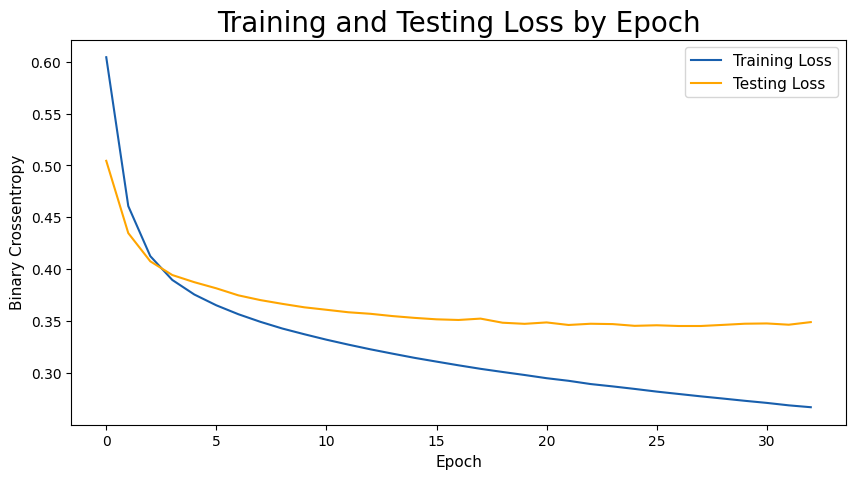

In [134]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')
plt.title('Training and Testing Loss by Epoch', fontsize = 20)
plt.xlabel('Epoch', fontsize = 11)
plt.ylabel('Binary Crossentropy', fontsize = 11)
plt.legend(fontsize = 11)

Acá podemos ver como varía el accuracy por epoch:

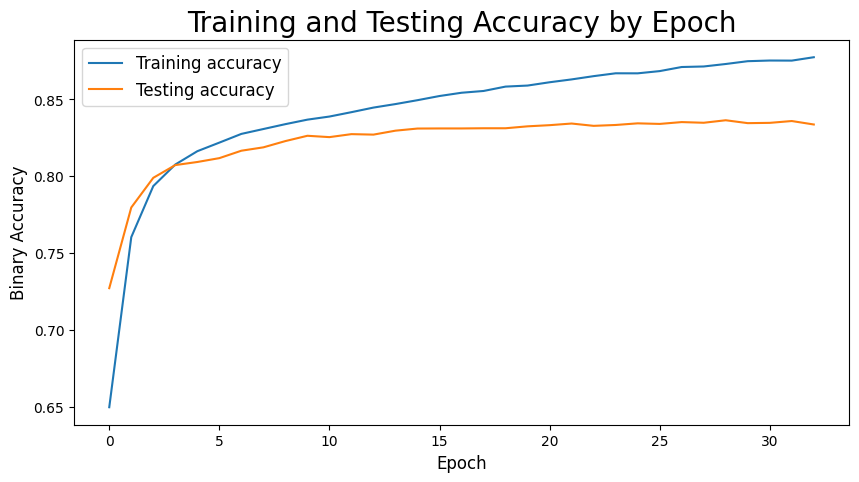

In [135]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Testing accuracy')
plt.title('Training and Testing Accuracy by Epoch', fontsize = 20)
plt.xlabel('Epoch', fontsize = 12)
plt.ylabel('Binary Accuracy', fontsize = 12)
plt.legend(fontsize = 12)

En el siguiente gráfico se puede ver el area bajo la curva:

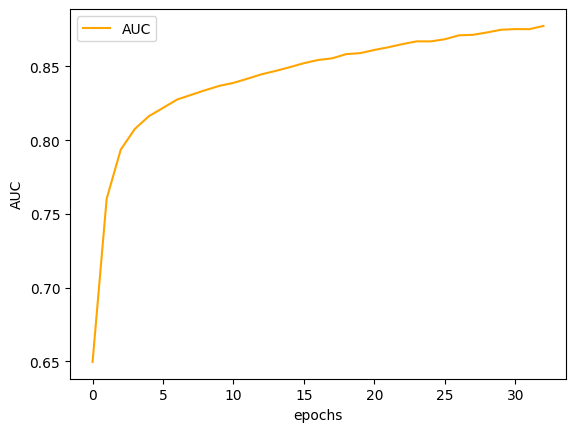

In [136]:
plt.plot(history.history['accuracy'], color='orange', label='AUC')
plt.xlabel("epochs")
plt.ylabel("AUC")
plt.legend()

In [137]:
train_score = modelo_2.evaluate(x_train,
                       y_train,
                       verbose=1)
test_score = modelo_2.evaluate(x_test,
                       y_test,
                       verbose=1)
labels = modelo_2.metrics_names

print('')
print(f'Training Accuracy: {train_score[1]}')
print(f'Testing Accuracy: {test_score[1]}')

499/499 [==============================] - 1s 1ms/step - loss: 0.3490 - accuracy: 0.8337

Training Accuracy: 0.880780816078186
Testing Accuracy: 0.8336888551712036


In [138]:
y_pred = modelo_2.predict(x_test)

499/499 [==============================] - 1s 1ms/step


In [139]:
y_pred_binario = np.where(y_pred > 0.3851, 1, 0)

accuracy = accuracy_score(y_test, y_pred_binario)
recall = recall_score(y_test, y_pred_binario)
f1 = f1_score(y_test, y_pred_binario,)
precision = precision_score(y_test, y_pred_binario)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8337515683814304
Recall: 0.8824617661568821
Precision: 0.8082919114324446
f1 score: 0.8437499999999999


In [140]:
#Reporte de Clasificación
print(classification_report(y_test,y_pred_binario))

              precision    recall  f1-score   support

           0       0.87      0.78      0.82      7832
           1       0.81      0.88      0.84      8108

    accuracy                           0.83     15940
   macro avg       0.84      0.83      0.83     15940
weighted avg       0.84      0.83      0.83     15940



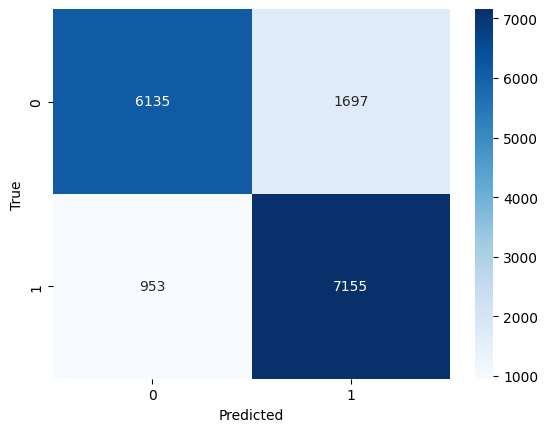

In [141]:
#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred_binario)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Modelo 3

Seteamos la cantidad de capas, neuronas por capa y funcion de activacion.

In [142]:
cant_clases = len(np.unique(y_train))
cant_inputs = len(train[0])

modelo_3 = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=[cant_inputs]),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

Vamos a utilizar EarlyStopping como funcion de regularizacion para evitar el overfitting.

In [143]:
es = EarlyStopping(monitor='val_loss', patience=5) 

Acá podemos ver un resumen del modelo.

In [144]:
modelo_3.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 64)                10944     
                                                                 
 dense_28 (Dense)            (None, 32)                2080      
                                                                 
 dense_29 (Dense)            (None, 1)                 33        
                                                                 
Total params: 13,057
Trainable params: 13,057
Non-trainable params: 0
_________________________________________________________________


Seteamos parámetros para este primer modelo: cantidad de epochs y optimizador a utilizar, y luego entrenamos el modelo

In [145]:
epochs = 50

In [146]:
modelo_3.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
    )

history = modelo_3.fit(x_train, y_train, epochs=epochs, batch_size=64, verbose=1, validation_data = (x_test, y_test), callbacks=[es])

Epoch 1/50
582/582 [==============================] - 2s 3ms/step - loss: 0.4112 - accuracy: 0.7944 - val_loss: 0.3698 - val_accuracy: 0.8192
Epoch 2/50
582/582 [==============================] - 1s 2ms/step - loss: 0.3342 - accuracy: 0.8389 - val_loss: 0.3484 - val_accuracy: 0.8307
Epoch 3/50
582/582 [==============================] - 1s 2ms/step - loss: 0.3102 - accuracy: 0.8526 - val_loss: 0.3374 - val_accuracy: 0.8399
Epoch 4/50
582/582 [==============================] - 1s 2ms/step - loss: 0.2942 - accuracy: 0.8649 - val_loss: 0.3340 - val_accuracy: 0.8398
Epoch 5/50
582/582 [==============================] - 1s 2ms/step - loss: 0.2826 - accuracy: 0.8708 - val_loss: 0.3386 - val_accuracy: 0.8407
Epoch 6/50
582/582 [==============================] - 2s 3ms/step - loss: 0.2721 - accuracy: 0.8763 - val_loss: 0.3399 - val_accuracy: 0.8411
Epoch 7/50
582/582 [==============================] - 2s 3ms/step - loss: 0.2640 - accuracy: 0.8813 - val_loss: 0.3360 - val_accuracy: 0.8440
Epoch 

En el siguiente gráfico podemos ver como varía el error por epoch:

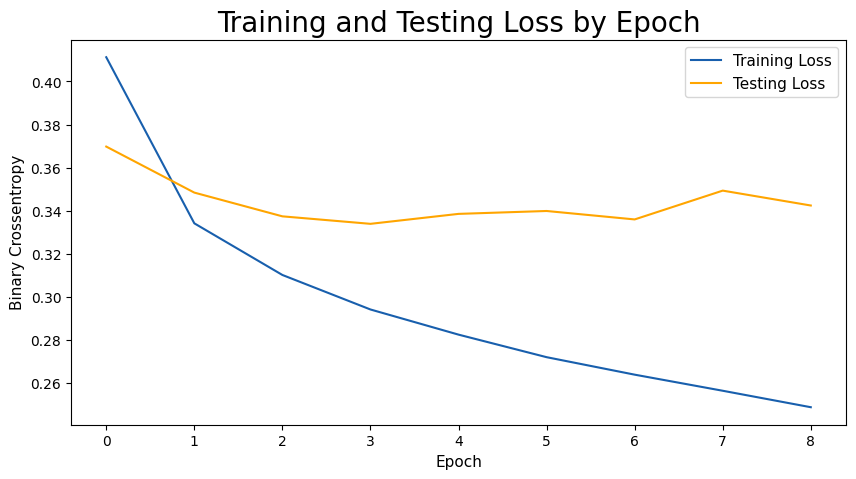

In [147]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')
plt.title('Training and Testing Loss by Epoch', fontsize = 20)
plt.xlabel('Epoch', fontsize = 11)
plt.ylabel('Binary Crossentropy', fontsize = 11)
plt.legend(fontsize = 11)

Acá podemos ver como varía el accuracy por epoch:

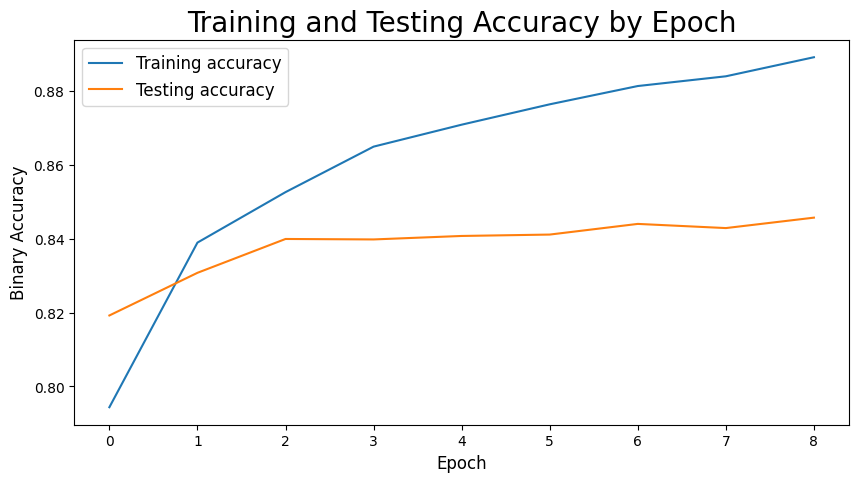

In [148]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Testing accuracy')
plt.title('Training and Testing Accuracy by Epoch', fontsize = 20)
plt.xlabel('Epoch', fontsize = 12)
plt.ylabel('Binary Accuracy', fontsize = 12)
plt.legend(fontsize = 12)

En el siguiente gráfico se puede ver el area bajo la curva:

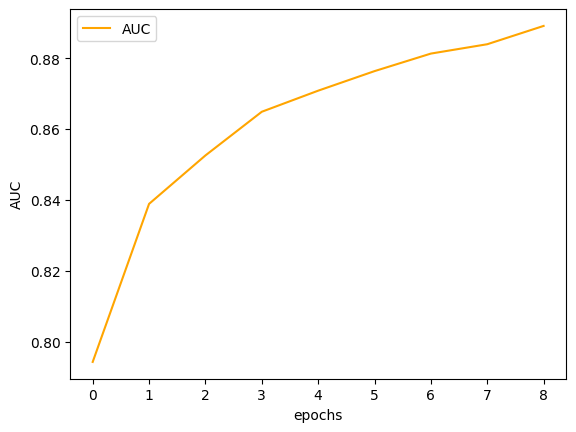

In [149]:
plt.plot(history.history['accuracy'], color='orange', label='AUC')
plt.xlabel("epochs")
plt.ylabel("AUC")
plt.legend()

In [150]:
train_score = modelo_3.evaluate(x_train,
                       y_train,
                       verbose=1)
test_score = modelo_3.evaluate(x_test,
                       y_test,
                       verbose=1)
labels = modelo_3.metrics_names

print('')
print(f'Training Accuracy: {train_score[1]}')
print(f'Testing Accuracy: {test_score[1]}')

499/499 [==============================] - 1s 2ms/step - loss: 0.3425 - accuracy: 0.8457

Training Accuracy: 0.9009464383125305
Testing Accuracy: 0.8456712961196899


In [151]:
y_pred = modelo_3.predict(x_test)

499/499 [==============================] - 1s 1ms/step


In [152]:
y_pred_binario = np.where(y_pred > 0.3851, 1, 0)

accuracy = accuracy_score(y_test, y_pred_binario)
recall = recall_score(y_test, y_pred_binario)
f1 = f1_score(y_test, y_pred_binario,)
precision = precision_score(y_test, y_pred_binario)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8451693851944793
Recall: 0.873334977799704
Precision: 0.8309082375029336
f1 score: 0.8515935057125678


In [153]:
#Reporte de Clasificación
print(classification_report(y_test,y_pred_binario))

              precision    recall  f1-score   support

           0       0.86      0.82      0.84      7832
           1       0.83      0.87      0.85      8108

    accuracy                           0.85     15940
   macro avg       0.85      0.84      0.84     15940
weighted avg       0.85      0.85      0.84     15940



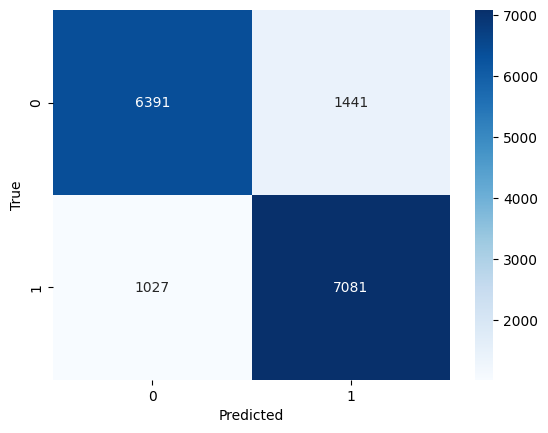

In [154]:
#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred_binario)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Submission

El mejor modelo es el modelo 3 con un f1 score de 0.85 asique guardamos este modelo y usamos su prediccion para kaggle.

In [155]:
pickle.dump(modelo_3, open('neural_network_grupo29.pickle', 'wb'))

In [158]:
X_submission = test
y_pred_test = modelo_3.predict(X_submission)
y_pred_test_binario = np.where(y_pred_test > 0.5, 1, 0)

830/830 [==============================] - 1s 2ms/step


In [159]:
df_submission = pd.DataFrame({'id': original_test['id'], 'is_canceled': y_pred_test_binario.flatten()})
df_submission.to_csv('nn02.csv', index=False)